In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary and mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build dataset

def build_dataset(words):
    block_size = 3 # content length: how many characters to predict next one
    x, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            context = context[1:] + [ix] # crop and append

    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
xtr.shape, ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [7]:
n_embd = 10
n_hidden = 200
vocab_size = 27
block_size = 3

g = torch.Generator().manual_seed(2147483647)
c = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [c, w1, b1, w2, b2, bngain, bnbias]

In [8]:
sum(p.nelement() for p in parameters) # total parameters

12297

In [9]:
for p in parameters:
    p.requires_grad = True

In [10]:
stepi = []
lossi = []
stepi = []
max_steps = 200000
batch_size = 32

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = c[xtr[ix]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Batch Normalization - (preactivations - mean)/variance then scale and shift
    
    # estimate batch norm post-training values
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # 32, 100
    logits = h @ w2 + b2 # 32, 27
    loss = F.cross_entropy(logits, ytr[ix])
    #print(loss.item())
    
    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    #break

print(loss.item())

2.296679973602295


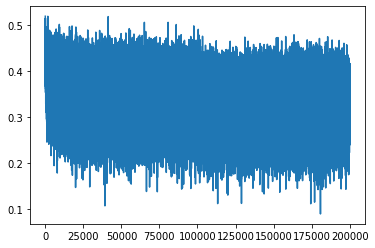

In [11]:
plt.plot(lossi)

In [12]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x, y ={
        'train': (xtr, ytr),
        'val': (xdev, ydev),
        'test': (xte, yte)
    }[split]
    emb = c[xdev]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # 32, 100
    logits = h @ w2 + b2 # 32, 27
    loss = F.cross_entropy(logits, ydev)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1066744327545166
val 2.1066744327545166


In [13]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = c[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ w1 + b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact) # 32, 100
        logits = h @ w2 + b2 # 32, 27
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlavela.
jhavi.
kimri.
rehtyn.
kanden.
jazonte.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quinthorocken.
jadiquinte.
madiaryxia.
kael.
dusti.
edde.
oia.


## Prettifying

In [14]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [15]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [16]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [17]:
# hyperparameters
n_embd = 10 # embedding dimensionality
n_hidden = 100 # number of neruons in hidden layer
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27 # letters + stop char
block_size = 3 # context size

In [18]:
c = torch.randn((vocab_size, n_embd), generator=g)
net = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # make last layer less confident
    net[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in net[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [c] + [p for layer in net for p in layer.parameters()] # add embedding layer and get parameters
print(sum(p.nelement() for p in parameters)) # print number of total parameters
for p in parameters:
    p.requires_grad = True # enable gradient tracking

46924


In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # batch data
    ix = torch.randint(0, xtr.shape[0], (batch_size,), generator=g) # random index
    xb, yb = xtr[ix], ytr[ix]
    
    # forward pass
    emb = c[xb] # embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concat vectors
    for layer in net:
        x = layer(x)
    loss = F.cross_entropy(x, yb)
    
    # back pass
    for layer in net:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 0.1 if i < 100000 else 0.01 # learning rate + decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2880
  10000/ 200000: 2.3139
  20000/ 200000: 2.0990
  30000/ 200000: 1.9273
  40000/ 200000: 2.1110
  50000/ 200000: 2.1956
  60000/ 200000: 1.7521
  70000/ 200000: 2.1468
  80000/ 200000: 2.2422
  90000/ 200000: 1.7301
 100000/ 200000: 2.3226
 110000/ 200000: 2.1911
 120000/ 200000: 2.0660
 130000/ 200000: 1.8067
 140000/ 200000: 1.7208
 150000/ 200000: 1.8728
 160000/ 200000: 2.0226
 170000/ 200000: 1.9664
 180000/ 200000: 2.2835
 190000/ 200000: 1.9255


In [20]:
# evaluation
@ torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (xtr, ytr),
        'val': (xdev, ydev),
        'test': (xte, yte)
    }[split]
    emb = c[x]
    x = emb.view(emb.shape[0], -1)
    for layer in net:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put net into eval mode
for layer in net:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.001737594604492
val 2.0836873054504395


In [21]:
# sample model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass through the net
        emb = c[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in net:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amillivia.
jari.
reety.
skaan.
kenleigh.
farelynn.
kaeli.
nellara.
chaiivon.
legend.
bron.
catessan.
shon.
rai.
addicia.
elo.
dearisia.
kaellissa.
mel.
